# IE582
## HW3
### Fatih Kubilay Yavuz - 2015402018
The task was making a prediction for an energy data. I have used Naive approach, Linear Regression and Lasso Regression

# Task A

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
consumption_df=pd.read_csv("RealTimeConsumption-01012016-01112019.csv")
consumption_df["Datetime"]=consumption_df["Date"]+" "+consumption_df["Hour"]
consumption_df["Datetime"]=pd.to_datetime(consumption_df["Datetime"])
consumption_df["Consumption (MWh)"]=consumption_df["Consumption (MWh)"].apply(lambda x:float(x.split(",")[1])+int(x.split(",")[0])*1000)
consumption_df.head()

,Date,Hour,Consumption (MWh),Datetime
0,01.01.2016,00:00,26277.24,2016-01-01 00:00:00
1,01.01.2016,01:00,24991.82,2016-01-01 01:00:00
2,01.01.2016,02:00,23532.61,2016-01-01 02:00:00
3,01.01.2016,03:00,22464.78,2016-01-01 03:00:00
4,01.01.2016,04:00,22002.91,2016-01-01 04:00:00


In [3]:
consumption_df.tail()

,Date,Hour,Consumption (MWh),Datetime
33595,01.11.2019,19:00,36056.96,2019-01-11 19:00:00
33596,01.11.2019,20:00,35130.19,2019-01-11 20:00:00
33597,01.11.2019,21:00,33947.64,2019-01-11 21:00:00
33598,01.11.2019,22:00,32877.69,2019-01-11 22:00:00
33599,01.11.2019,23:00,31590.75,2019-01-11 23:00:00


In [4]:
consumption_df.columns=['Date', 'Hour', 'Consumption', 'Datetime']

In [5]:
consumption_df["Cons_lag_48"]=np.append(np.full(48,np.nan),consumption_df[["Consumption","Datetime"]].iloc[:-48]["Consumption"].values)
consumption_df["Cons_lag_168"]=np.append(np.full(168,np.nan),consumption_df[["Consumption","Datetime"]].iloc[:-168]["Consumption"].values)

In [6]:
consumption_df.isna().sum()

Date              0
Hour              0
Consumption       0
Datetime          0
Cons_lag_48      48
Cons_lag_168    168
dtype: int64

In [7]:
lag_48=consumption_df[["Consumption","Datetime","Cons_lag_48"]].copy()
lag_48=lag_48.dropna()
lag_48

,Consumption,Datetime,Cons_lag_48
48,27613.96,2016-03-01 00:00:00,26277.24
49,25779.28,2016-03-01 01:00:00,24991.82
50,24566.31,2016-03-01 02:00:00,23532.61
51,23878.42,2016-03-01 03:00:00,22464.78
52,23511.38,2016-03-01 04:00:00,22002.91
53,23672.32,2016-03-01 05:00:00,21957.08
54,23827.08,2016-03-01 06:00:00,22203.54
55,23405.11,2016-03-01 07:00:00,21844.16
56,24638.72,2016-03-01 08:00:00,23094.73
57,26802.38,2016-03-01 09:00:00,25202.27


In [9]:
lag_48["Abs_Perc_Err"]=abs((lag_48["Consumption"]-lag_48["Cons_lag_48"])/lag_48["Consumption"])
mape_48=(lag_48["Abs_Perc_Err"].sum()/len(lag_48))*100
print("The Naive forecast of lag 48 gives us MAPE of : {} %".format(mape_48));

The Naive forecast of lag 48 gives us MAPE of : 7.900900711989816 %


In [10]:
lag_168=consumption_df[["Consumption","Datetime","Cons_lag_168"]].copy()
lag_168=lag_168.dropna()
lag_168["Abs_Perc_Err"]=abs((lag_168["Consumption"]-lag_168["Cons_lag_168"])/lag_168["Consumption"])
mape_168=(lag_168["Abs_Perc_Err"].sum()/len(lag_168))*100
print("The Naive forecast of lag 168 gives us MAPE of : {} %".format(mape_168));

The Naive forecast of lag 168 gives us MAPE of : 5.007890585375337 %


### Hourly 

In [11]:
lag_48_mapes={}
lag_168_mapes={}
lag_168["Hour"]=lag_168["Datetime"].apply(lambda x:x.hour)
lag_48["Hour"]=lag_48["Datetime"].apply(lambda x:x.hour)

for hour_ in range(24):
    lag_168_mapes[hour_]=lag_168.loc[lag_168["Hour"]==hour_]["Abs_Perc_Err"].mean()
    lag_48_mapes[hour_]=lag_48.loc[lag_48["Hour"]==hour_]["Abs_Perc_Err"].mean()

# Task B

In [13]:
from sklearn.linear_model import LinearRegression
lin_model_df=consumption_df.copy().dropna()
model=LinearRegression()
model.fit(lin_model_df[["Cons_lag_48","Cons_lag_168"]],lin_model_df["Consumption"])
preds=model.predict(lin_model_df[["Cons_lag_48","Cons_lag_168"]])
reel_vals=lin_model_df["Consumption"].values
mape_lin=sum([abs(el-reel_vals[i])/reel_vals[i] for i,el in enumerate(preds)])/len(preds)
print("The Linear regression model gives us MAPE of : {} %".format(mape_lin*100));

The Linear regression model gives us MAPE of : 4.942726721918271 %


In [18]:
print("The models intercepts and coefficients are: {}, {}, {} ".format(model.intercept_,model.coef_[0],model.coef_[1]))

The models intercepts and coefficients are: 1624.7995291585503, 0.3256692540954328, 0.6245573483323618 


# Task C

In [19]:
lin_models={}
hours_=consumption_df["Hour"].unique()
mapes_lin=[]
for hour_ in hours_:
    lin_model_df=consumption_df.loc[consumption_df["Hour"]==hour_].copy().dropna()
    model=LinearRegression()
    model.fit(lin_model_df[["Cons_lag_48","Cons_lag_168"]],lin_model_df["Consumption"])
    preds=model.predict(lin_model_df[["Cons_lag_48","Cons_lag_168"]])
    reel_vals=lin_model_df["Consumption"].values
    mape_lin=sum([abs(el-reel_vals[i])/reel_vals[i] for i,el in enumerate(preds)])/len(preds)
    lin_models[hour_]=model
    print("The Linear regression model of {}'s hour gives us MAPE of : {} %".format(hour_,mape_lin*100));
    print("The models intercepts and coefficients are: {}, {}, {} ".format(model.intercept_,model.coef_[0],model.coef_[1]));
    mapes_lin.append(mape_lin*100)
print("Mean mape: ",np.mean(mapes_lin))

The Linear regression model of 00:00's hour gives us MAPE of : 3.700640143521003 %
The models intercepts and coefficients are: 2404.2254678324352, 0.5023768707545057, 0.4200415083990582 
The Linear regression model of 01:00's hour gives us MAPE of : 3.8255129497793567 %
The models intercepts and coefficients are: 2320.7718751269567, 0.5068178468708716, 0.41428038109197984 
The Linear regression model of 02:00's hour gives us MAPE of : 3.943254437069522 %
The models intercepts and coefficients are: 2384.578467070889, 0.508504437116864, 0.40728210568211115 
The Linear regression model of 03:00's hour gives us MAPE of : 4.0094393098488395 %
The models intercepts and coefficients are: 2431.9248396035437, 0.5013359217477362, 0.4105302348304273 
The Linear regression model of 04:00's hour gives us MAPE of : 3.9990980644490595 %
The models intercepts and coefficients are: 2459.8975154944674, 0.4826828639982257, 0.42708703914269264 
The Linear regression model of 05:00's hour gives us MAPE of 

# Task D

In [20]:
wide_cons_df=consumption_df.copy().dropna()
wide_cons_df=pd.pivot_table(wide_cons_df,values=["Cons_lag_48","Cons_lag_168"],index=["Date"],columns="Hour")
wide_cons_df.columns=[i+"_hour_"+j[:2] for i,j in wide_cons_df.columns]
wide_cons_df

,Cons_lag_168_hour_00,Cons_lag_168_hour_01,Cons_lag_168_hour_02,Cons_lag_168_hour_03,Cons_lag_168_hour_04,Cons_lag_168_hour_05,Cons_lag_168_hour_06,Cons_lag_168_hour_07,Cons_lag_168_hour_08,Cons_lag_168_hour_09,...,Cons_lag_48_hour_14,Cons_lag_48_hour_15,Cons_lag_48_hour_16,Cons_lag_48_hour_17,Cons_lag_48_hour_18,Cons_lag_48_hour_19,Cons_lag_48_hour_20,Cons_lag_48_hour_21,Cons_lag_48_hour_22,Cons_lag_48_hour_23
Date,,,,,,,,,,,,,,,,,,,,,
01.01.2017,30810.85,28730.61,27128.43,26318.76,26071.24,26019.13,26204.72,26483.50,26614.49,28460.54,...,35299.73,34943.99,35218.12,35493.42,35095.14,34223.46,33532.49,32681.67,32961.95,31863.79
01.01.2018,30158.75,28480.68,27478.88,26623.11,26789.84,27039.91,28359.26,31230.31,36707.48,39978.29,...,36015.28,35378.60,35210.19,36026.08,36602.62,35592.16,34818.43,33947.69,33560.20,32348.83
01.01.2019,31191.30,29400.24,28123.43,27573.01,27353.81,27682.56,28867.13,31501.53,36040.12,38925.10,...,31469.61,31202.59,32044.55,33700.28,35213.48,34761.30,34247.01,33470.76,32521.30,31323.83
01.02.2016,28167.47,26516.66,25339.39,24773.74,24711.58,25145.67,26151.07,27508.65,33542.39,37790.78,...,34697.06,34002.74,33457.63,34897.48,34596.05,33538.44,32664.18,31927.94,32124.59,30873.86
01.02.2017,31829.52,29820.31,28562.31,27936.52,27720.64,27814.78,28712.32,30738.65,35391.57,39260.58,...,41265.16,40919.66,40506.23,39882.26,38839.83,38121.88,37135.36,36094.01,35722.46,34342.79
01.02.2018,34055.77,32179.58,30534.81,29751.88,29132.66,29425.09,30362.12,32285.75,37194.71,40523.63,...,37584.61,37145.83,37500.04,38455.56,39451.26,39077.40,38247.82,37207.51,36416.90,35428.85
01.02.2019,32021.03,30105.80,28730.71,27957.44,27802.84,27860.77,28777.35,30766.99,34779.00,37410.76,...,38193.88,37715.65,37679.04,37892.32,37993.32,37201.55,36480.18,35541.14,34719.67,33566.63
01.03.2016,27972.52,26367.45,25288.39,24790.77,24726.94,25239.39,25751.39,27332.18,31721.19,34027.79,...,26032.31,25786.34,25836.52,27066.61,29276.68,29245.03,28828.17,28291.62,28488.72,26940.20
01.03.2017,31244.22,29383.59,28091.90,27556.14,27500.80,27786.74,29470.10,31435.34,35785.20,38383.63,...,36596.43,35928.37,35657.14,35528.51,35652.68,36405.29,35462.05,34333.31,33682.34,32538.83


In [21]:
from sklearn.linear_model import LassoCV
from tqdm import tqdm

In [22]:
lasso_models={}
hours_=consumption_df["Hour"].unique()
mapes_lasso=[]
for hour_ in hours_:
    lasso_model_actual=consumption_df[consumption_df["Hour"]==hour_].iloc[7:,2].values
    model=LassoCV(cv=10,random_state=1337,tol=0.0001,max_iter=10000)
    model.fit(wide_cons_df.values,lasso_model_actual)
    preds=model.predict(wide_cons_df.values)
    mape_lin=sum([abs(el-lasso_model_actual[i])/lasso_model_actual[i] for i,el in enumerate(preds)])/len(preds)
    lasso_models[hour_]=model
    print("The Lasso regression model of {}'s hour gives us MAPE of : {} %".format(hour_,mape_lin*100));
    mapes_lasso.append(mape_lin*100)
print("Mean mape: ",np.mean(mapes_lasso))

The Lasso regression model of 00:00's hour gives us MAPE of : 7.401240510576931 %
The Lasso regression model of 01:00's hour gives us MAPE of : 7.596953253933083 %
The Lasso regression model of 02:00's hour gives us MAPE of : 7.627294440543339 %
The Lasso regression model of 03:00's hour gives us MAPE of : 7.5272125029806025 %
The Lasso regression model of 04:00's hour gives us MAPE of : 7.30679147145157 %
The Lasso regression model of 05:00's hour gives us MAPE of : 7.081054390340884 %
The Lasso regression model of 06:00's hour gives us MAPE of : 7.62320513730796 %
The Lasso regression model of 07:00's hour gives us MAPE of : 8.748376337470896 %
The Lasso regression model of 08:00's hour gives us MAPE of : 10.611762110492345 %
The Lasso regression model of 09:00's hour gives us MAPE of : 11.060312648481094 %
The Lasso regression model of 10:00's hour gives us MAPE of : 10.586261980510052 %
The Lasso regression model of 11:00's hour gives us MAPE of : 10.385550077280776 %
The Lasso reg

In [23]:
for hour_ in hours_:
    print("The penalization term chosen by the regression for the hour {} is: {}".format(hour_,lasso_models[hour_].alpha_))
    print("Intercept: ",lasso_models[hour_].intercept_)
    [print("{}: {}".format(el,lasso_models[hour_].coef_[i])) for i,el in enumerate(wide_cons_df.columns)];

The penalization term chosen by the regression for the hour 00:00 is: 349487.34588820516
Intercept:  30605.74616974007
Cons_lag_168_hour_00: -0.0
Cons_lag_168_hour_01: -0.0
Cons_lag_168_hour_02: -0.0
Cons_lag_168_hour_03: -0.0
Cons_lag_168_hour_04: -0.0
Cons_lag_168_hour_05: -0.0
Cons_lag_168_hour_06: -0.0
Cons_lag_168_hour_07: -0.0
Cons_lag_168_hour_08: -0.0
Cons_lag_168_hour_09: -0.0
Cons_lag_168_hour_10: -0.0
Cons_lag_168_hour_11: -0.0
Cons_lag_168_hour_12: -0.0
Cons_lag_168_hour_13: -0.0
Cons_lag_168_hour_14: -0.0
Cons_lag_168_hour_15: -0.0
Cons_lag_168_hour_16: -0.0
Cons_lag_168_hour_17: -0.0
Cons_lag_168_hour_18: -0.0
Cons_lag_168_hour_19: -0.0
Cons_lag_168_hour_20: -0.0
Cons_lag_168_hour_21: -0.0
Cons_lag_168_hour_22: -0.0
Cons_lag_168_hour_23: -0.0
Cons_lag_48_hour_00: 0.0
Cons_lag_48_hour_01: 0.0
Cons_lag_48_hour_02: 0.0
Cons_lag_48_hour_03: 0.0
Cons_lag_48_hour_04: 0.0
Cons_lag_48_hour_05: 0.0
Cons_lag_48_hour_06: 0.0
Cons_lag_48_hour_07: 0.0
Cons_lag_48_hour_08: 0.0
Cons_lag

Cons_lag_48_hour_16: 0.0
Cons_lag_48_hour_17: 0.0
Cons_lag_48_hour_18: 0.0
Cons_lag_48_hour_19: 0.0
Cons_lag_48_hour_20: 0.0
Cons_lag_48_hour_21: 0.0
Cons_lag_48_hour_22: 0.0
Cons_lag_48_hour_23: 0.0
The penalization term chosen by the regression for the hour 06:00 is: 232290.261920132
Intercept:  26695.521378074678
Cons_lag_168_hour_00: -0.0
Cons_lag_168_hour_01: -0.0
Cons_lag_168_hour_02: -0.0
Cons_lag_168_hour_03: -0.0
Cons_lag_168_hour_04: -0.0
Cons_lag_168_hour_05: -0.0
Cons_lag_168_hour_06: -0.0
Cons_lag_168_hour_07: -0.0
Cons_lag_168_hour_08: -0.0
Cons_lag_168_hour_09: -0.0
Cons_lag_168_hour_10: -0.0
Cons_lag_168_hour_11: -0.0
Cons_lag_168_hour_12: -0.0
Cons_lag_168_hour_13: -0.0
Cons_lag_168_hour_14: -0.0
Cons_lag_168_hour_15: -0.0
Cons_lag_168_hour_16: -0.0
Cons_lag_168_hour_17: -0.0
Cons_lag_168_hour_18: -0.0
Cons_lag_168_hour_19: -0.0
Cons_lag_168_hour_20: -0.0
Cons_lag_168_hour_21: -0.0
Cons_lag_168_hour_22: -0.0
Cons_lag_168_hour_23: -0.0
Cons_lag_48_hour_00: 0.0
Cons_lag_

Cons_lag_48_hour_07: 0.0
Cons_lag_48_hour_08: 0.0
Cons_lag_48_hour_09: 0.0
Cons_lag_48_hour_10: 0.0
Cons_lag_48_hour_11: 0.01868091496643164
Cons_lag_48_hour_12: 0.0
Cons_lag_48_hour_13: 0.0
Cons_lag_48_hour_14: 0.009444214878253738
Cons_lag_48_hour_15: 0.0
Cons_lag_48_hour_16: 0.0
Cons_lag_48_hour_17: 0.0
Cons_lag_48_hour_18: 0.0
Cons_lag_48_hour_19: 0.0
Cons_lag_48_hour_20: 0.0
Cons_lag_48_hour_21: 0.0
Cons_lag_48_hour_22: 0.0
Cons_lag_48_hour_23: 0.0
The penalization term chosen by the regression for the hour 12:00 is: 443033.9821384658
Intercept:  33643.629439458346
Cons_lag_168_hour_00: -0.0
Cons_lag_168_hour_01: -0.0
Cons_lag_168_hour_02: -0.0
Cons_lag_168_hour_03: -0.0
Cons_lag_168_hour_04: -0.0
Cons_lag_168_hour_05: -0.0
Cons_lag_168_hour_06: -0.0
Cons_lag_168_hour_07: -0.0
Cons_lag_168_hour_08: -0.0
Cons_lag_168_hour_09: -0.0
Cons_lag_168_hour_10: -0.0
Cons_lag_168_hour_11: -0.0
Cons_lag_168_hour_12: -0.0
Cons_lag_168_hour_13: -0.0
Cons_lag_168_hour_14: -0.0
Cons_lag_168_hour_

Cons_lag_48_hour_00: 0.0
Cons_lag_48_hour_01: 0.0
Cons_lag_48_hour_02: 0.0
Cons_lag_48_hour_03: 0.0
Cons_lag_48_hour_04: 0.0
Cons_lag_48_hour_05: 0.0
Cons_lag_48_hour_06: 0.0
Cons_lag_48_hour_07: 0.0
Cons_lag_48_hour_08: 0.0
Cons_lag_48_hour_09: 0.0
Cons_lag_48_hour_10: 0.0
Cons_lag_48_hour_11: 0.0
Cons_lag_48_hour_12: 0.0
Cons_lag_48_hour_13: 0.0
Cons_lag_48_hour_14: 0.03836175261436513
Cons_lag_48_hour_15: 0.0
Cons_lag_48_hour_16: 0.0
Cons_lag_48_hour_17: 0.0
Cons_lag_48_hour_18: 0.0
Cons_lag_48_hour_19: 0.0
Cons_lag_48_hour_20: 0.0
Cons_lag_48_hour_21: 0.0
Cons_lag_48_hour_22: 0.0
Cons_lag_48_hour_23: 0.0
The penalization term chosen by the regression for the hour 18:00 is: 346627.25566268567
Intercept:  34351.62555929472
Cons_lag_168_hour_00: -0.0
Cons_lag_168_hour_01: -0.0
Cons_lag_168_hour_02: -0.0
Cons_lag_168_hour_03: -0.0
Cons_lag_168_hour_04: -0.0
Cons_lag_168_hour_05: -0.0
Cons_lag_168_hour_06: -0.0
Cons_lag_168_hour_07: -0.0
Cons_lag_168_hour_08: -0.0
Cons_lag_168_hour_09: 

Cons_lag_168_hour_19: -0.0
Cons_lag_168_hour_20: -0.0
Cons_lag_168_hour_21: -0.0
Cons_lag_168_hour_22: -0.0
Cons_lag_168_hour_23: -0.0
Cons_lag_48_hour_00: 0.0
Cons_lag_48_hour_01: 0.0
Cons_lag_48_hour_02: 0.0
Cons_lag_48_hour_03: 0.0
Cons_lag_48_hour_04: 0.0
Cons_lag_48_hour_05: 0.0
Cons_lag_48_hour_06: 0.0
Cons_lag_48_hour_07: 0.0
Cons_lag_48_hour_08: 0.0
Cons_lag_48_hour_09: 0.0
Cons_lag_48_hour_10: 0.0
Cons_lag_48_hour_11: 0.0
Cons_lag_48_hour_12: 0.0
Cons_lag_48_hour_13: 0.0
Cons_lag_48_hour_14: 0.0262475991371379
Cons_lag_48_hour_15: 0.0
Cons_lag_48_hour_16: 0.0
Cons_lag_48_hour_17: 0.0
Cons_lag_48_hour_18: 0.0
Cons_lag_48_hour_19: 0.0
Cons_lag_48_hour_20: 0.0
Cons_lag_48_hour_21: 0.0
Cons_lag_48_hour_22: 0.0
Cons_lag_48_hour_23: 0.0


The Lasso regression performs worse than the others. Maybe, the reason is that we don't give the model enough time to converge.

# Part F

In [24]:
mapes_df=pd.DataFrame()
mapes_df["Lag_168"]=np.array(list(lag_168_mapes.values()))*100
mapes_df["Lag_48"]= np.array(list(lag_48_mapes.values()))*100
mapes_df["Linear_Reg"]=mapes_lin
mapes_df["Lasso_Reg"]=mapes_lasso
mapes_df

,Lag_168,Lag_48,Linear_Reg,Lasso_Reg
0,4.073532,5.008644,3.700640,7.401241
1,4.170764,5.151735,3.825513,7.596953
2,4.200353,5.316900,3.943254,7.627294
3,4.187462,5.452011,4.009439,7.527213
4,4.101790,5.591868,3.999098,7.306791
5,4.072587,5.852693,4.036887,7.081054
6,4.228659,6.540981,4.244592,7.623205
7,4.641696,8.309105,4.841557,8.748376
8,5.397612,11.915928,5.920614,10.611762
9,5.820492,12.277209,6.287922,11.060313


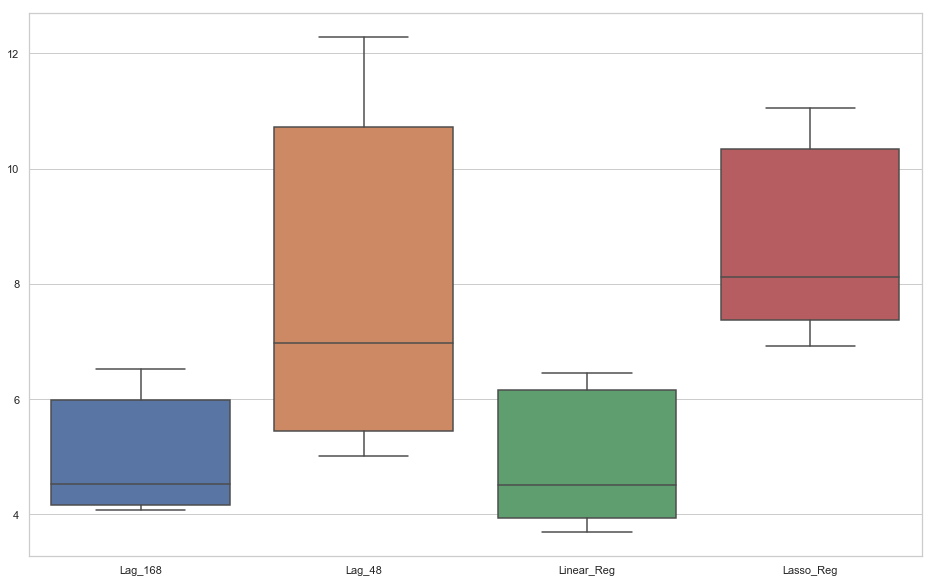

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(16,10))
sns.boxplot(data=mapes_df)

As it can be seen:

    The naive approach performs better when we take Lag 168 as feature.
    However, we cannot say the same thing for the 48 hours lag. 
        This may stem from people's behaviour in the same days of the week. 
    When we take a look at the Linear Regression model:
        We see that, overall, it outperforms all of others.
    Out of all 4, Lasso performs the worst, this is because we haven't specified enough parameters for the lasso, and didn't give enough time to converge.
        